In [1]:
# https://pytorch.org/
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.models import vgg16
from torchvision.models.detection import maskrcnn_resnet50_fpn

import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image


In [2]:
# Provide the file paths
train_dir = '/datasets/COCO-2017/train2017'
val_dir = '/datasets/COCO-2017/val2017'
test_dir = '/datasets/COCO-2017/test2017'
ann_dir = '/datasets/COCO-2017/anno2017'
train_split = 'train2017'
val_split = 'val2017'
test_split = 'test2017'

coco_train = COCO(f'{ann_dir}/instances_{train_split}.json')
coco_val = COCO(f'{ann_dir}/instances_{val_split}.json')
coco_test = COCO(f'{ann_dir}/image_info_{test_split}.json')

loading annotations into memory...
Done (t=14.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [3]:
# # Mask generation functions
def mask_transform_train(annotation):
    if type(annotation) is Image.Image: # dont process if Image
        return annotation
    
    #print(len(annotation))
    if len(annotation) == 0:
        combined_mask = np.zeros((512,512)).astype(np.uint8) * 255
        combined_mask = Image.fromarray(combined_mask)
        return combined_mask
    
    combined_mask = coco_train.annToMask(annotation[0])
    if len(annotation) > 1:
        for ann in annotation[1:]:
            # Extract the segmentation mask as a binary image
            mask = coco_train.annToMask(ann)
            combined_mask = np.logical_or(combined_mask, mask)

    # Convert the binary mask to an integer mask (
    combined_mask = combined_mask.astype(np.uint8) * 255
    combined_mask = Image.fromarray(combined_mask)

    return combined_mask

def mask_transform_val(annotation):
    if type(annotation) is Image.Image: # dont process if Image
        return annotation
    
    if len(annotation) == 0:
        combined_mask = np.zeros((512,512)).astype(np.uint8) * 255
        combined_mask = Image.fromarray(combined_mask)
        return combined_mask
    
    combined_mask = coco_val.annToMask(annotation[0])
    if len(annotation) > 1:
        for ann in annotation[1:]:
            # Extract the segmentation mask as a binary image
            mask = coco_val.annToMask(ann)
            combined_mask = np.logical_or(combined_mask, mask)

    # Convert the binary mask to an integer mask (
    combined_mask = combined_mask.astype(np.uint8) * 255
    combined_mask = Image.fromarray(combined_mask)

    return combined_mask

def mask_transform_test(annotation):
    if type(annotation) is Image.Image: # dont process if Image
        return annotation
    
    if len(annotation) == 0:
        combined_mask = np.zeros((512,512)).astype(np.uint8) * 255
        combined_mask = Image.fromarray(combined_mask)
        return combined_mask
    
    combined_mask = coco_test.annToMask(annotation[0])
    if len(annotation) > 1:
        for ann in annotation[1:]:
            # Extract the segmentation mask as a binary image
            mask = coco_train.annToMask(ann)
            combined_mask = np.logical_or(combined_mask, mask)

    # Convert the binary mask to an integer mask (
    combined_mask = combined_mask.astype(np.uint8) * 255
    combined_mask = Image.fromarray(combined_mask)

    return combined_mask

def run_image_thru_resnet50(image):  ## Preprocess feature extraction 
    backbone = torchvision.models.resnet50(pretrained=True)
    backbone = nn.Sequential(*list(backbone.children())[:-2])
    #out_processed = backbone(image)
    out_processed = backbone(torch.unsqueeze(image, 0).to(torch.float32)).detach().squeeze(0)
    return out_processed

In [4]:
# # Apply the transforms to image and target separately

image_transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    T.Lambda(run_image_thru_resnet50)
 ])


target_transform_train = T.Compose([
    T.Lambda(mask_transform_train),
    T.Resize((256,256)),
    T.ToTensor()
 ])
target_transform_val = T.Compose([
    T.Lambda(mask_transform_val),
    T.Resize((256,256)),
    T.ToTensor()
 ])
target_transform_test = T.Compose([
    T.Lambda(mask_transform_test),
    T.Resize((256,256)),
    T.ToTensor()
 ])


train_dataset = dset.CocoDetection(root=train_dir, annFile=f'{ann_dir}/instances_{train_split}.json', 
                                  transform=image_transform, target_transform=target_transform_train)
val_dataset = dset.CocoDetection(root=val_dir, annFile=f'{ann_dir}/instances_{val_split}.json',
                                transform=image_transform, target_transform=target_transform_val)
test_dataset = dset.CocoDetection(root=test_dir, annFile=f'{ann_dir}/image_info_{test_split}.json', 
                                 transform=image_transform, target_transform=target_transform_test)


loading annotations into memory...
Done (t=14.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [5]:
batchSize = 5

train_subset_ids = list(range(6000))
train_dataset_sub = Subset(train_dataset, train_subset_ids) # Taking few training examples for now

train_loader = DataLoader(
    train_dataset_sub, batch_size=batchSize, shuffle=True, num_workers=1
)
val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

print("Training Set Size:", len(train_dataset_sub))
print("Validation Set Size:", len(val_dataset))
print("Test Set Size:", len(test_dataset))

USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

Training Set Size: 6000
Validation Set Size: 5000
Test Set Size: 40670
using device: cuda


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2048, 8, 8])
torch.Size([1, 256, 256])


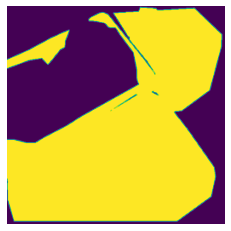

torch.Size([2048, 8, 8])
torch.Size([1, 256, 256])


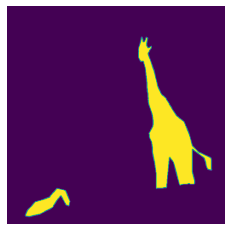

torch.Size([2048, 8, 8])
torch.Size([1, 256, 256])


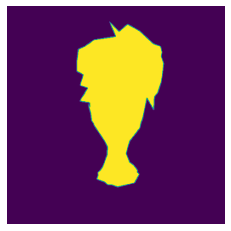

In [6]:
# Display input size for U-Net decoder and target output
for i in range(3):
#for id, (image, targets) in enumerate(train_loader):
    image, targets = train_dataset[i]
    print(torch.squeeze(image).shape)
    print(targets.shape)
    
    # Convert the image tensor to a NumPy array
    #image_np = torch.squeeze(image).permute(1, 2, 0).numpy()
    target_np = torch.squeeze(targets).numpy()
#     # Display the image 
#     plt.imshow(image_np)
#     plt.axis('off')
#     plt.show()

    # Display the annotations
    #print(targets)
    plt.imshow(target_np)
    plt.axis('off')
    plt.show()


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


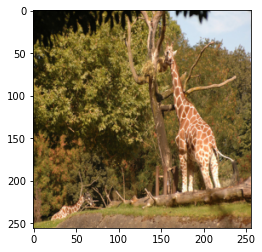

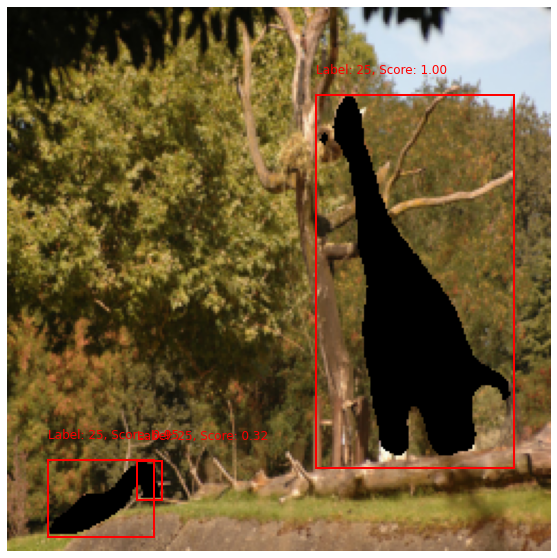

In [7]:
# Runninf pretrained image detection and segmentation

# Load the pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
#source: https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html

# Set the model to evaluation mode
model.eval()

# Load and preprocess the input image
#image = Image.open('path_to_your_image.jpg')  # Replace with the path to your own image
image_tensor = train_dataset[1][0]   ## LOAD UR IMAGE (datatype: tensor)
image = image_tensor.permute(1, 2, 0).numpy()
#image_tensor = T.ToTensor()(image)
image_tensor = image_tensor.unsqueeze(0)
#image_tensor = image_tensor.cuda()

# Pass the image through the model
with torch.no_grad():
    outputs = model(image_tensor)

# Extract the predicted bounding boxes, labels, masks, and scores
#pred_boxes = outputs[0]['boxes'].cpu().numpy()
#pred_labels = outputs[0]['labels'].cpu().numpy()
#pred_masks = outputs[0]['masks'].cpu().numpy()
#pred_scores = outputs[0]['scores'].cpu().numpy()

pred_boxes = outputs[0]['boxes'].numpy()
pred_labels = outputs[0]['labels'].numpy()
pred_masks = outputs[0]['masks'].numpy()
pred_scores = outputs[0]['scores'].numpy()


plt.imshow(image)
# Display the input image with bounding boxes and masks
fig, ax = plt.subplots(1, figsize=(10, 10))
#ax.imshow(image)

for box, label, mask, score in zip(pred_boxes, pred_labels, pred_masks, pred_scores):
    # Draw the bounding box
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    
   
    # Apply the mask
    mask = mask[0, :, :, None]
    mask_binary = (mask > 0.5).astype(float)
    mask_binary = mask_binary.squeeze()
    mask_image = Image.fromarray(mask_binary)
    mask_image_rgb = np.array(mask_image.convert('RGB'))
    tp_mask = (mask_image_rgb == 1)
    #ax.imshow(mask_binary, cmap='jet', alpha=0.7)
    #ax.imshow(mask_image_rgb+image)
    image[tp_mask]=0 # make pixel value ZERO 

    # Add label and score
    label_str = f'Label: {label}, Score: {score:.2f}'
    ax.text(x1, y1 - 10, label_str, color='red', fontsize=12)

ax.imshow(image)
plt.axis('off')
plt.show()

In [7]:
class conv_relu_block(nn.Module):
    def __init__(self, in_c, out_c):
        super(conv_relu_block, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super(encoder_block, self).__init__()
        self.conv = conv_relu_block(in_c, out_c)
        
    def forward(self, inputs):
        x = self.conv(inputs)
        return x

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super(decoder_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        
    def forward(self, inputs, skip):
        x = self.up(inputs)
        diffY = x.size()[2]-skip.size()[2] 
        diffX = x.size()[3]-skip.size()[3]  
        skip = nn.functional.pad(skip, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([skip, x], dim=1)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.e1 = encoder_block(3, 64)
        self.maxpool1 = nn.MaxPool2d((2, 2))
        self.e2 = encoder_block(64, 128)
        self.maxpool2 = nn.MaxPool2d((2, 2))
        self.e3 = encoder_block(128, 256)
        self.maxpool3 = nn.MaxPool2d((2, 2))
        self.e4 = encoder_block(256, 512)
        self.maxpool4 = nn.MaxPool2d((2, 2))
        
        # Bottleneck 
        self.b = conv_relu_block(512, 1024)
        
        # Decoder
        self.d1 = decoder_block(1024, 1024)
        self.d1_conv = conv_relu_block(1024+512, 512)
        self.d2 = decoder_block(512, 512)
        self.d2_conv = conv_relu_block(512+256, 256)
        self.d3 = decoder_block(256, 256)
        self.d3_conv = conv_relu_block(256+128, 128)
        self.d4 = decoder_block(128, 128)
        self.d4_conv = conv_relu_block(128+64, 64)
        
        # Classifier 
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs):
        # Encoder
        p1 = self.e1(inputs)
        p1 = self.maxpool1(p1)
        p2 = self.e2(p1)
        p2 = self.maxpool2(p2)
        p3 = self.e3(p2)
        p3 = self.maxpool3(p3)
        p4 = self.e4(p3)
        p4 = self.maxpool4(p4)
        
        # Bottleneck 
        b = self.b(p4)
        
        # Decoder
        d1 = self.d1(b, p4)
        d1 = self.d1_conv(d1)
        d2 = self.d2(d1, p3)
        d2 = self.d2_conv(d2)
        d3 = self.d3(d2, p2)
        d3 = self.d3_conv(d3)
        d4 = self.d4(d3, p1)
        d4 = self.d4_conv(d4)

        # Classifier 
        outputs = self.outputs(d4)
        return outputs


In [9]:
class decoder_block_noskip(nn.Module):
    def __init__(self, in_c, out_c):
        super(decoder_block_noskip, self).__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        
    def forward(self, inputs):
        x = self.up(inputs)
        return x

class UNet_Decoder(nn.Module):
    def __init__(self):
        super(UNet_Decoder, self).__init__()
        # Decoder
        self.d0 = decoder_block_noskip(2048, 2048)
        self.d0_conv = conv_relu_block(2048, 1024)
        self.d1 = decoder_block_noskip(1024, 1024)
        self.d1_conv = conv_relu_block(1024, 512)
        self.d2 = decoder_block_noskip(512, 512)
        self.d2_conv = conv_relu_block(512, 256)
        self.d3 = decoder_block_noskip(256, 256)
        self.d3_conv = conv_relu_block(256, 128)
        self.d4 = decoder_block_noskip(128, 128)
        self.d4_conv = conv_relu_block(128, 64)
        
        # Classifier 
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs):  
        # Decoder
        d0 = self.d0(inputs)
        d0 = self.d0_conv(d0)
        d1 = self.d1(d0)
        d1 = self.d1_conv(d1)
        d2 = self.d2(d1)
        d2 = self.d2_conv(d2)
        d3 = self.d3(d2)
        d3 = self.d3_conv(d3)
        d4 = self.d4(d3)
        d4 = self.d4_conv(d4)

        # Classifier 
        outputs = self.outputs(d4)
        return outputs

In [21]:
def calculate_accuracy(dataset, model):
    # Outputs and targets are the predicted and ground truth segmentation maps respectively
    # Convert the predicted probabilities to binary predictions (0 or 1)
    accuracy = 0
    count = 0
    for images, targets in dataset[0:100]:
        images = images.to(device)
        targets = targets.to(device)
        images_ = torch.unsqueeze(images, 0)
        outputs = model(images_)
        predicted = (outputs > 0.5).float()

        # Calculate the pixel-wise accuracy
        correct_pixels = (predicted == targets).sum().item()
        total_pixels = targets.numel()
        accuracy = accuracy + correct_pixels / total_pixels
        count = count + 1
    accuracy = accuracy / count
    return accuracy

In [ ]:
print_every = 500

# Create an instance of the U-Net model
model = UNet_Decoder()
model = model.to(device)

# Define loss function and optimizer
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    running_loss = 0.0
    t = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        t = t + 1
        if (t + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{10}], Loss: {running_loss / len(train_loader)}")
#             acc = calculate_accuracy(train_dataset, model)
#             print('Train accuracy: %.2f' % acc)
#             print()

torch.save(model.state_dict(), 'segment_unet_model.pth')

Epoch [1/10], Loss: 0.21071770330270131
Epoch [1/10], Loss: 0.4026360290745894
Epoch [2/10], Loss: 0.17990818098187447
Epoch [2/10], Loss: 0.35897283274680375
Epoch [3/10], Loss: 0.17090422670046487
Epoch [3/10], Loss: 0.34247033345202604
Epoch [4/10], Loss: 0.16250327217082183
Epoch [4/10], Loss: 0.3275639644513528
Epoch [5/10], Loss: 0.15655129324644804
